# Assignment 5: Network Models and Statistical Analysis

In [2]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import numpy as np

import random 
import matplotlib.pyplot as plt
from scipy import stats
from typing import Tuple, List, Dict, Union
from sklearn.metrics.cluster import normalized_mutual_info_score
from matplotlib.colors import ListedColormap

## Part 1: Structural Properties of the Graph

In [4]:
def load_football_graph() -> nx.Graph:    
    G = nx.read_gml("football.gml")
    return G    

### 1.1

In [6]:
def calculate_graph_statistics(G: nx.Graph) -> Dict[str, Union[float, List[int]]]:
    """
    Inputs:
    G: NetworkX graph object
    
    Returns:
    Dictionary of graph statistics
    
    """
    
    # Make sure the graph is connect otherwise use max connect component
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len))

    # Calc the dia for longest shortest path
    diameter = nx.diameter(G)
    
    # Clac the avg short length
    cpl = nx.average_shortest_path_length(G)
    
    # Calc the avg clus
    avg_clustering = nx.average_clustering(G)
    
    # Based on triangle cal transitivity
    transitivity = nx.transitivity(G)
    
    # Calc the assort coef
    assortativity = nx.degree_assortativity_coefficient(G)
    
    # Mapping the degrees 
    degree_sequence = [d for n, d in G.degree()]
    
    # Construct the dict 
    graph_statistics = {
        'diameter': diameter,
        'cpl': cpl,
        'avg_clustering': avg_clustering,
        'transitivity': transitivity,
        'assortativity': assortativity,
        'degree_sequence': degree_sequence
    }
    return graph_statistics

### 1.2

In [8]:
def sweep_louvain_resolutions(G: nx.Graph, min_resolution: int=1, max_resolution: int=10) -> Tuple[List[int], List[float]]:
    """
    Inputs:
    G: NetworkX graph object
    min_resolution : integer
    max_resolution : integer
    
    Returns:
    Tuple of list of resolutions and list of NMIs
    
    """


    # Abstract the commnuity by nodes
    true_communities = {}
    for node in G.nodes():
        community = G.nodes[node]['value']
        if community not in true_communities:
            true_communities[community] = []
        true_communities[community].append(node)
    
    # Transfer to list
    true_partition = list(true_communities.values())
    
    # Adding labels 
    true_labels = {}
    for i, comm in enumerate(true_partition):
        for node in comm:
            true_labels[node] = i
            
    # To identify the resolution and NMI
    resolutions = list(range(min_resolution, max_resolution + 1))
    nmis = []
    
    # Use Louvain communty to check every resolutiion
    for resolution in resolutions:
        # Apply Louvian
        communities = louvain_communities(G, resolution=resolution)
        
        # Adding perdict label for communities 
        pred_labels = {}
        for i, comm in enumerate(communities):
            for node in comm:
                pred_labels[node] = i
        
        # Acquire all node lists 
        nodes = list(G.nodes())
        true_label_list = [true_labels[node] for node in nodes]
        pred_label_list = [pred_labels[node] for node in nodes]
        
        # Calc the NMI and evalute the score
        nmi = normalized_mutual_info_score(true_label_list, pred_label_list)
        nmis.append(nmi)
    
    return resolutions, nmis


def plot_nmi_vs_resolution(resolutions: List[int], nmis: List[float], save: bool=False) -> None:
    """
    Inputs:
    min_resolution : integer
    max_resolution : integer
    save: boolean
    
    Returns:
    None
    
    """
    


    plt.figure(figsize=(10, 6))
    plt.plot(resolutions, nmis, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Resolution Parameter')
    plt.ylabel('Normalized Mutual Information (NMI)')
    plt.title('NMI vs Resolution for Louvain Community Detection')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(resolutions)
    
    # Mark the best resolution point by adding "Best" feature
    best_idx = np.argmax(nmis)
    best_resolution = resolutions[best_idx]
    best_nmi = nmis[best_idx]
    plt.scatter([best_resolution], [best_nmi], color='red', s=100, zorder=5,
                label=f'Best Resolution = {best_resolution}, NMI = {best_nmi:.4f}')
    plt.legend()
    
    if save:
        plt.savefig('1_2_1.png')
    plt.tight_layout()
    plt.show()

### 1.3

In [10]:
def calculate_best_partition(G: nx.Graph, resolutions: List[int], nmis: List[float]) -> Tuple[int, List[set[str]]]:
    """
    Inputs:
    G: NetworkX graph object
    resolutions : a list of integer
    nmis :a list of float
    
    Returns:
    Tuple of resolution and partition
    
    """


    #  Find the highest NMI Index 
    best_idx = np.argmax(nmis)
    best_resolution = resolutions[best_idx]
    
    # Calc the communities by applying best resolution 
    partition = louvain_communities(G, resolution=best_resolution)
    
    return best_resolution, partition


def plot_best_partition(G: nx.Graph, partition: List[set], save: bool=False) -> None:
    """
    Inputs:
    G: NetworkX graph object
    partition : List[str]
    save: boolean
    
    Returns:
    None
    
    """
    
    # Graph created 
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    
    # Abstract the real communites values and nodes 
    nodes = list(G.nodes())
    
    # Make sure those two graph are same, using seed = 42
    node_positions = nx.spring_layout(G, seed=42)
    
    # Abstract the information from communities
    ground_truth_communities = {}
    for node in nodes:
        community_id = G.nodes[node]['value']
        if community_id not in ground_truth_communities:
            ground_truth_communities[community_id] = []
        ground_truth_communities[community_id].append(node)
    
    # Plot the community
    ax = axes[0]
    
    # Adding color for thoes communities 
    from matplotlib.colors import hsv_to_rgb
    num_true_communities = len(ground_truth_communities)
    
    for i, (_, community_nodes) in enumerate(ground_truth_communities.items()):
        # Making color based on hsv for better view 
        hue = i / num_true_communities
        # Use fixed color hue 
        color = hsv_to_rgb([hue, 0.8, 0.9])
        
        # Draw community nodes
        nx.draw_networkx_nodes(
            G, node_positions,
            nodelist=community_nodes,
            node_color=[color],
            node_size=80,
            ax=ax
        )
    
    # Draw edges
    nx.draw_networkx_edges(G, node_positions, width=0.5, alpha=0.5, ax=ax)
    ax.set_title('Ground Truth Communities', fontsize=14)
    ax.axis('off')
    
    # Draw Louvain
    ax = axes[1]
    
    # Adding colors for Louvain communites nodes 
    num_louvain_communities = len(partition)
    
    for i, community_nodes in enumerate(partition):
        # Making color based on hsv for better view 
        hue = i / num_louvain_communities
        color = hsv_to_rgb([hue, 0.8, 0.9])
        
        # Draw Louvain nodes
        nx.draw_networkx_nodes(
            G, node_positions,
            nodelist=list(community_nodes),
            node_color=[color],
            node_size=80,
            ax=ax
        )
    
    # Draw edges
    nx.draw_networkx_edges(G, node_positions, width=0.5, alpha=0.5, ax=ax)
    ax.set_title('Louvain Communities (Best Partition)', fontsize=14)
    ax.axis('off')
    
    # Add the super title 
    fig.suptitle(' Ground Truth vs Louvain Community Structure Compare', fontsize=16)
    plt.tight_layout()
    
    if save:
        plt.savefig('1_2_2.png')

    plt.show()

### 1.4

In [12]:
def calculate_inter_community_density(G: nx.Graph, partition: list) -> Tuple[np.ndarray, List[int]]:
    """
    Inputs:
    G: NetworkX graph object
    partition : list
    
    Returns:
    Tuple of np array and List[int], intercommunity connection density matrix
    
    """


    num_communities = len(partition)
    sizes = [len(community) for community in partition]
    
    # Ini the edge for counting matrix 
    edge_counts = np.zeros((num_communities, num_communities))
    
    # Create nodes to communites 
    node_to_community = {}
    for i, community in enumerate(partition):
        for node in community:
            node_to_community[node] = i
    
    # Count the edges for every communites 
    for u, v in G.edges():
        if u == v:  # ignore self loop 
            continue
            
        comm_u = node_to_community.get(u, None)
        comm_v = node_to_community.get(v, None)
        
        if comm_u is None or comm_v is None:
            continue
            
        edge_counts[comm_u, comm_v] += 1
        if comm_u != comm_v:  # Avoid the comm u being calculate 
            edge_counts[comm_v, comm_u] += 1  # update it 
    
    # Calc the size for matrix 
    p = np.zeros((num_communities, num_communities))
    for i in range(num_communities):
        for j in range(num_communities):
            if i == j:  # connections between same community
                max_edges = sizes[i] * (sizes[i] - 1) / 2
            else:  # connections between diff communities 
                max_edges = sizes[i] * sizes[j]
                
            if max_edges > 0:
                p[i, j] = edge_counts[i, j] / max_edges
    
    return p, sizes

def plot_p_matrix(p: np.ndarray, save: bool=False):
    """
    Inputs:
    p: np array, intercommunity connection density matrix
    save: boolean
    
    Returns:
    None
    """
    

    plt.figure(figsize=(12, 10))
    
    # Make a copy for p and make sure those dianoal won't affact our original matrix 
    p_plot = p.copy()
    np.fill_diagonal(p_plot, 0)  # make those to zero 
    
    # Making a heat map by yellow red 
    im = plt.imshow(p_plot, cmap='YlOrRd')
    
    # Add color bar for better view 
    cbar = plt.colorbar(im)
    cbar.set_label('Connection Density')
    
    # Adding labes 
    plt.xlabel('Community Index')
    plt.ylabel('Community Index')
    plt.title('Inter-community Connection Density Matrix')
    
    # We do not need grid line this part, removed 
    plt.grid(False)
    
    # Adding value labels 
    for i in range(p_plot.shape[0]):
        for j in range(p_plot.shape[1]):
            text_color = 'black' if p_plot[i, j] < 0.5 else 'white'
            plt.text(j, i, f'{p_plot[i, j]:.3f}', ha='center', va='center', color=text_color)
    
    if save:
        plt.savefig('1_3.png')
    plt.tight_layout()
    plt.show()

### 1.5

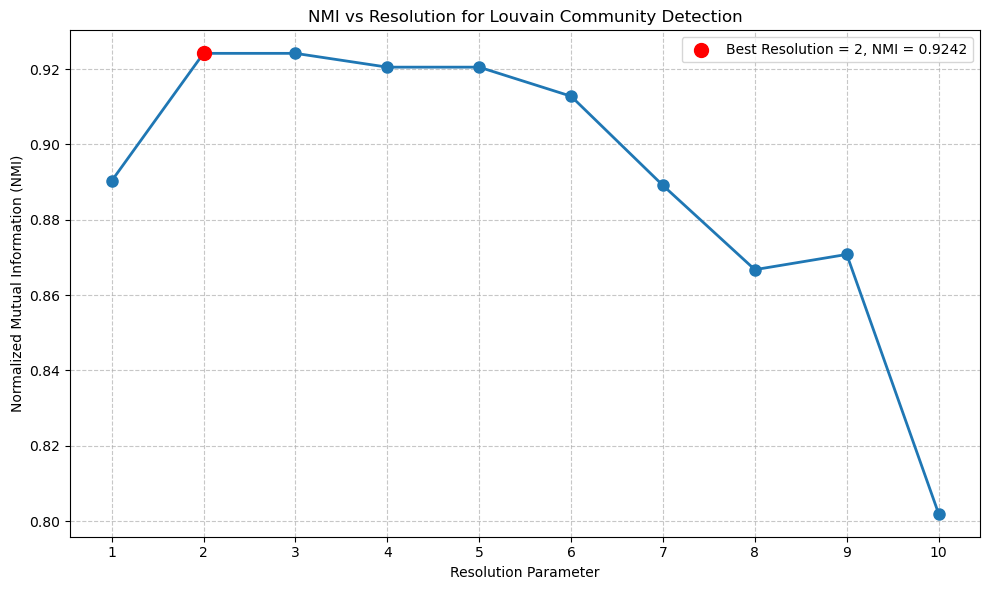

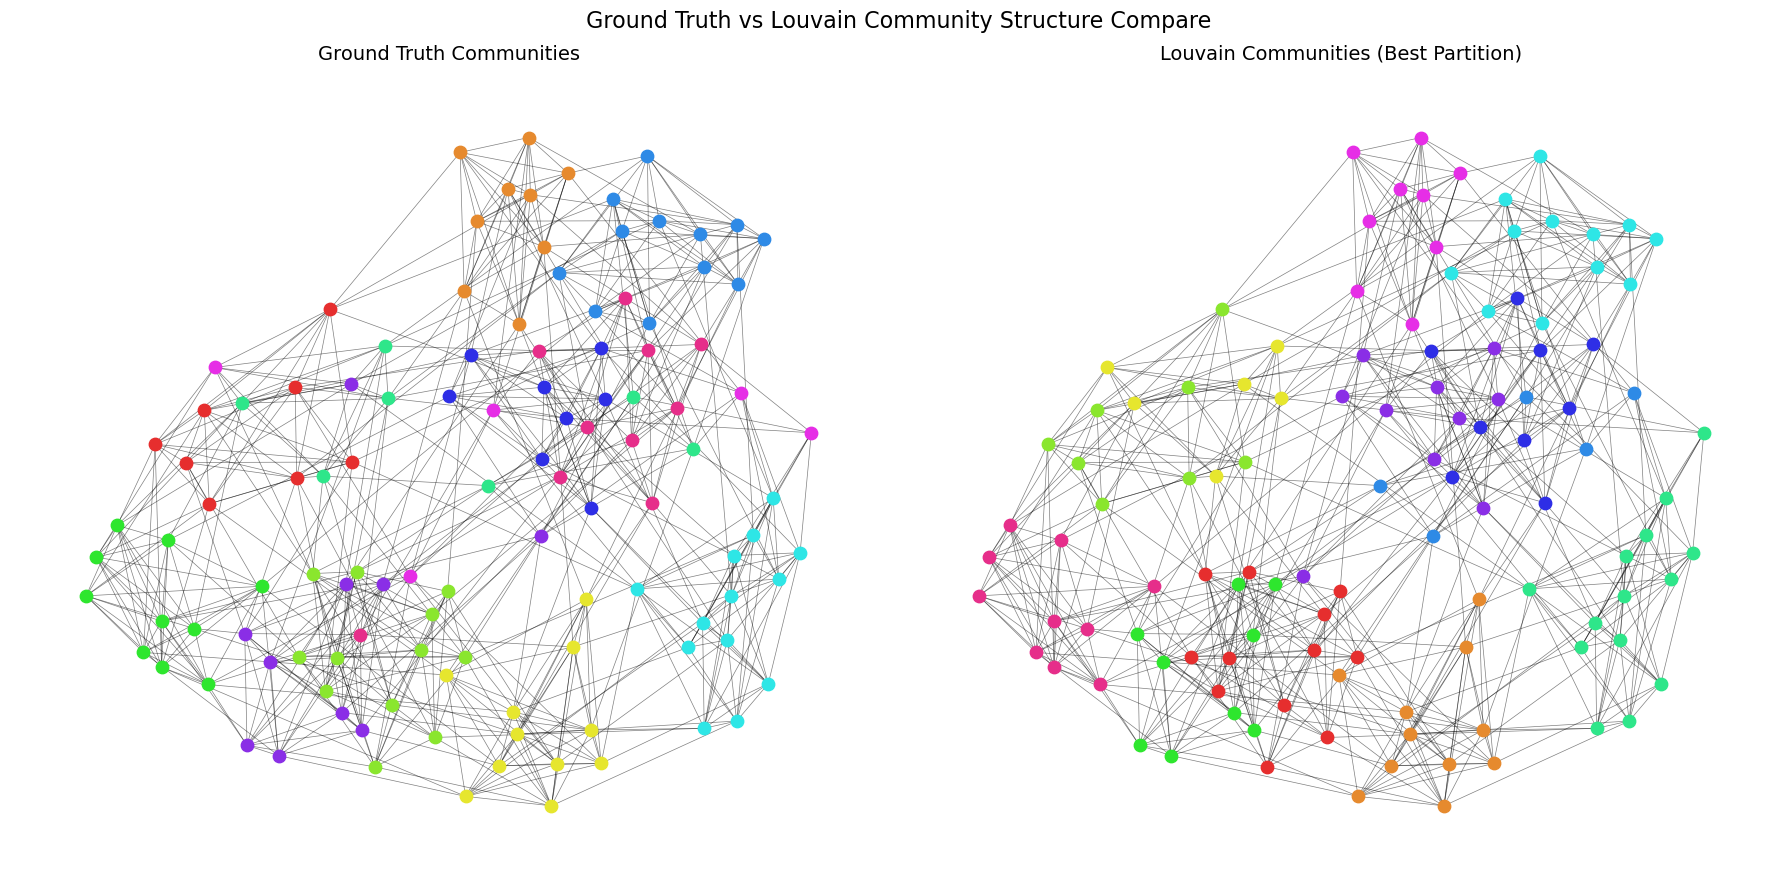

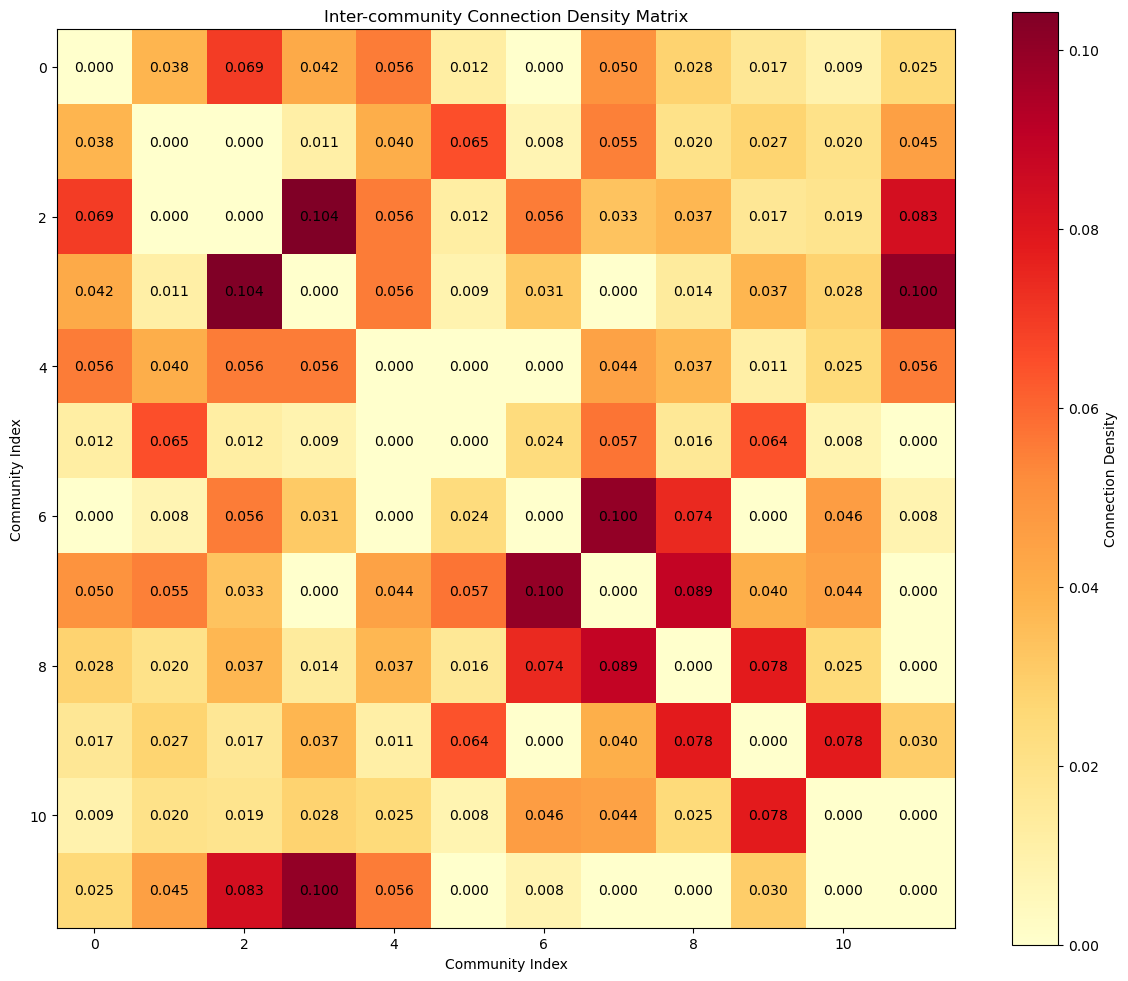

In [14]:
"""
1.5 cell
"""
G = load_football_graph()

# 1.1
graph_stats = calculate_graph_statistics(G)

# 1.2 
resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
plot_nmi_vs_resolution(resolutions, nmis)
plot_best_partition(G, partition)

# 1.3
p, sizes = calculate_inter_community_density(G, partition)
plot_p_matrix(p)


### 1.5 Written Response

Question: How does the resolution impact the NMI? Is the partition for the best NMI a good match to the ground truth? Justify your answer based on the visual plot and the NMI value itself.

Answer: 
Based on the visual plot and the NMI value, 

1. How resolution impact the NMI：
   - Highest NMI value = 0.9242 at resolution = 2
   - For lower resolution like 1, and high resolution like 6-10, the MNI decrease significantly
   - For low resolution, the algorithm tends to detect fewer large communities and vice versa

2. Yes, best NMI partition and real partition matching：
   - For NMI = 0.9242, which is very close to 1, means high consistency.
   - By observe the plots, we see same seed that is 42 means nodes in the two graphs are same.
   - Same color node groups in two graphs stay mostly consistent, showing community structure is well preserved.
   - Though some small community boundary differences exist, overall structure is very similar.
   - Density matrix shows connection strength between communities, helps verify partition reasonability.

In conclusion, by the Louvain algorithm with resolution = 2 closely match the true community structure. By using high NMI value and observe from the graphs

## Part 2: Graph Generators
### 2.1

In [17]:
def generate_configuration_graphs(degree_sequence: List[int], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    degree_sequence: List[int]
    n_graphs: int
    
    Returns:
    a list of graph
    """
    

    graphs = []
    for _ in range(n_graphs):
        # Use networkx for modeling
        G = nx.configuration_model(degree_sequence, create_using=nx.Graph())
        # Remove self loop and make sure the graph is connected 
        G.remove_edges_from(nx.selfloop_edges(G))

        if not nx.is_connected(G):
            G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
        graphs.append(G)
    return graphs

def generate_sbm_graphs(p: np.ndarray, sizes: List[int], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    p: np.ndarray, element (r,s) gives the density of edges going from the nodes of group r to nodes of group s.
    degree_sequence: List[int]
    n_graphs: int
    
    Returns:
    a list of graph
    """


    # Make sure the matrix are sym
    p_symmetric = np.zeros_like(p)
    for i in range(len(p)):
        for j in range(len(p)):
            p_symmetric[i][j] = (p[i][j] + p[j][i]) / 2
    
    # Validate 
    if not np.allclose(p_symmetric, p_symmetric.T, rtol=1e-10, atol=1e-10):
        raise ValueError("It is not symmetric, please chekck :(")
    
    # Close the range into 0 - 1
    p_symmetric = np.clip(p_symmetric, 0, 1)
    graphs = []
    
    for _ in range(n_graphs):
        try:
            # create random models, make sure the connection 
            G = nx.stochastic_block_model(sizes, p_symmetric)

            if not nx.is_connected(G):
                G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
            graphs.append(G)
        except Exception as e:
            print(f"***** SBM Generate error!! ***** : {e}")
            # Back to er random graph
            G = nx.erdos_renyi_graph(sum(sizes), 0.5)
            if not nx.is_connected(G):
                G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
            graphs.append(G)
    
    return graphs


### 2.2

In [19]:
def calculate_edge_probability(dendrogram: nx.DiGraph) -> Dict[str, Dict[str, float]]:
    """
    Inputs:
    dendrogram: NetworkX graph object    
    
    Returns:
    a dictionary of edge probabilities between all pairs of leaf nodes.
    """
    


    #  Accss all the leaf nodes 
    leaf_nodes = [node for node in dendrogram.nodes() if dendrogram.out_degree(node) == 0]
    # Ini the dict and calc the probality between all nodes 
    edge_probs = {node: {} for node in leaf_nodes}

    for i, node1 in enumerate(leaf_nodes):
        for node2 in leaf_nodes[i+1:]:  # Avoid leap calc
            # find the probality 
            prob = find_edge_probability(dendrogram, node1, node2)
            # store double side
            edge_probs[node1][node2] = prob
            edge_probs[node2][node1] = prob
    return edge_probs

def find_edge_probability(dendrogram: nx.DiGraph, node1: str, node2: str) -> float:
    # Acquire the root node and find the path
    root = [node for node in dendrogram.nodes() if dendrogram.in_degree(node) == 0][0]
    
    path1 = find_path(dendrogram, root, node1)
    path2 = find_path(dendrogram, root, node2)
    # Find the LCA
    lca = None
    for n1, n2 in zip(path1, path2):
        if n1 == n2:
            lca = n1
        else:
            break
    
    # If there's no LCA, return 0 
    if lca is None:
        return 0
    # Probality for LCA Node
    if 'p' in dendrogram.nodes[lca]:
        return float(dendrogram.nodes[lca]['p'])
    else:
        # Analysis the constrct of nodes 
        children = list(dendrogram.successors(lca))
        if len(children) == 2:
            left, right = children
            # FInd if those nodes are in diff trees
            in_left1 = is_descendant(dendrogram, left, node1)
            in_left2 = is_descendant(dendrogram, left, node2)
            if (in_left1 and not in_left2) or (not in_left1 and in_left2):
                # Set 0.5 as default HRG Prob
                return 0.5
    return 0

# Helper funciton for find the path from start to target, the shortest
def find_path(graph: nx.DiGraph, start: str, end: str) -> List[str]:
    if start == end:
        return [start]
    for neighbor in graph.successors(start):
        if is_descendant(graph, neighbor, end):
            return [start] + find_path(graph, neighbor, end)
    return []

# Check if descenant belong to ancestor
def is_descendant(graph: nx.DiGraph, ancestor: str, descendant: str) -> bool:
    if ancestor == descendant:
        return True
    if graph.out_degree(ancestor) == 0:
        return False
    for child in graph.successors(ancestor):
        if is_descendant(graph, child, descendant):
            return True
    return False

def generate_graph_from_prob(edge_probs: Dict[str, Dict[str, float]]) -> nx.Graph:
    """
    Inputs:
    edge_probs: a dictionary of edge probabilities between all pairs of leaf nodes.
    
    Returns:
    H: NetworkX graph object
    """

    # Create graph and adding nodes, adding edges by prob
    H = nx.Graph()
    H.add_nodes_from(edge_probs.keys())
    for node1 in edge_probs:
        for node2, prob in edge_probs[node1].items():
            # Avoid overleap
            if node1 < node2:
                # Adding edges by prob
                if random.random() < prob:
                    H.add_edge(node1, node2)
    return H


def generate_hrg_graphs(edge_probs: Dict[str, Dict[str, float]], n_graphs: int=100) -> List[nx.Graph]:
    """
    Inputs:
    edge_probs: a dictionary of edge probabilities between all pairs of leaf nodes.
    n_graphs: int
    
    Returns:
    a list of NetworkX graph object
    """


    graphs = []
    for _ in range(n_graphs):
        # Generate the graph and make sure the connection
        G = generate_graph_from_prob(edge_probs)
        if not nx.is_connected(G):
            G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
        graphs.append(G)
    return graphs

### 2.3

In [21]:
def calculate_generated_statistics(graphs: List[nx.Graph]) -> Dict[str, list]:
    """
    Inputs:
    graphs: a list of NetworkX graph object
    
    Returns:
    a dictionary of graph statistics
    """


    # Init dict 
    graph_statistics = {
        'diameter': [],
        'cpl': [],
        'avg_clustering': [],
        'transitivity': [],
        'assortativity': []
    }
    
    # Clac the graph and make sure the connection 
    for G in graphs:
        if not nx.is_connected(G):
            G = G.subgraph(max(nx.connected_components(G), key=len))
            
        # graph statistics
        graph_statistics['diameter'].append(nx.diameter(G))
        graph_statistics['cpl'].append(nx.average_shortest_path_length(G))
        graph_statistics['avg_clustering'].append(nx.average_clustering(G))
        graph_statistics['transitivity'].append(nx.transitivity(G))
        graph_statistics['assortativity'].append(nx.degree_assortativity_coefficient(G))
        
    return graph_statistics

def compare_generated_to_ground_truth(ground_truth_features: Dict[str, float], generated_features: Dict[str, List[float]]) -> Dict[str, float]:
    """
    Inputs:
    ground_truth_features: a dictionary of graph statistics
    generated_features: a dictionary of graph statistics
    
    Returns:
    a dictionary of one-sample t-test
    """


    p_vals = {}
    # T test for every feature 
    for feature in ['diameter', 'cpl', 'avg_clustering', 'transitivity', 'assortativity']:
        # Acquire true value and generated value 
        true_value = ground_truth_features[feature]
        gen_values = generated_features[feature]
        # Applying t test, store it 
        t_stat, p_value = stats.ttest_1samp(gen_values, true_value)
        p_vals[feature] = p_value
        
    return p_vals


def plot_graph_statistics(graph_statistics: List[Dict[str, list]], save: bool=False) -> None:
    """
    Inputs:
    graph_statistics: a dictionary of graph statistics
    
    Returns:
    None
    """

    # import data
    ground_truth = graph_statistics[0]
    config_stats = graph_statistics[1]
    sbm_stats = graph_statistics[2]
    hrg_stats = graph_statistics[3]
    
    # Adding features 
    features = ['diameter', 'cpl', 'avg_clustering', 'transitivity', 'assortativity']
    
    # Create the fig
    fig, axes = plt.subplots(1, 5, figsize=(20, 6))
    
    # Give makes, labels 
    model_names = ['Ground Truth', 'Config', 'SBM', 'HRG']
    
    for i, feature in enumerate(features):
        # Transfer Ground Truth vaules into list 
        gt_value = [ground_truth[feature]] if not isinstance(ground_truth[feature], list) else ground_truth[feature]
        
        # Prepare for modeling data 
        config_data = config_stats[feature]
        sbm_data = sbm_stats[feature]
        hrg_data = hrg_stats[feature]
        
        # Combine data
        data = [gt_value, config_data, sbm_data, hrg_data]
        
        # Plot the box plot and set features 
        axes[i].boxplot(data, tick_labels=model_names)
        
        axes[i].set_title(feature.capitalize())
        axes[i].set_ylabel('Value')
    
    plt.suptitle('Comparison of Network Statistics Across Different Graph Models', fontsize=14)
    plt.tight_layout()
    
    if save:
        plt.savefig('2_3.png')
    
    plt.show()

Configuration Model t-test
{'diameter': 3.0711227357497874e-09, 'cpl': 9.97873979831323e-143, 'avg_clustering': 1.5030875591896926e-177, 'transitivity': 9.193563319651252e-179, 'assortativity': 2.4431368993389159e-57}
Stochastic Block Model t-test
{'diameter': 6.29722218858136e-09, 'cpl': 0.05922466709794651, 'avg_clustering': 5.505599482540436e-30, 'transitivity': 0.43056901147957394, 'assortativity': 7.279458288113294e-45}
HRG Model t-test
{'diameter': 0.00038731224982966104, 'cpl': 7.925425877308529e-10, 'avg_clustering': 8.306078336607063e-34, 'transitivity': 0.1535145006909518, 'assortativity': 6.391538658464939e-49}


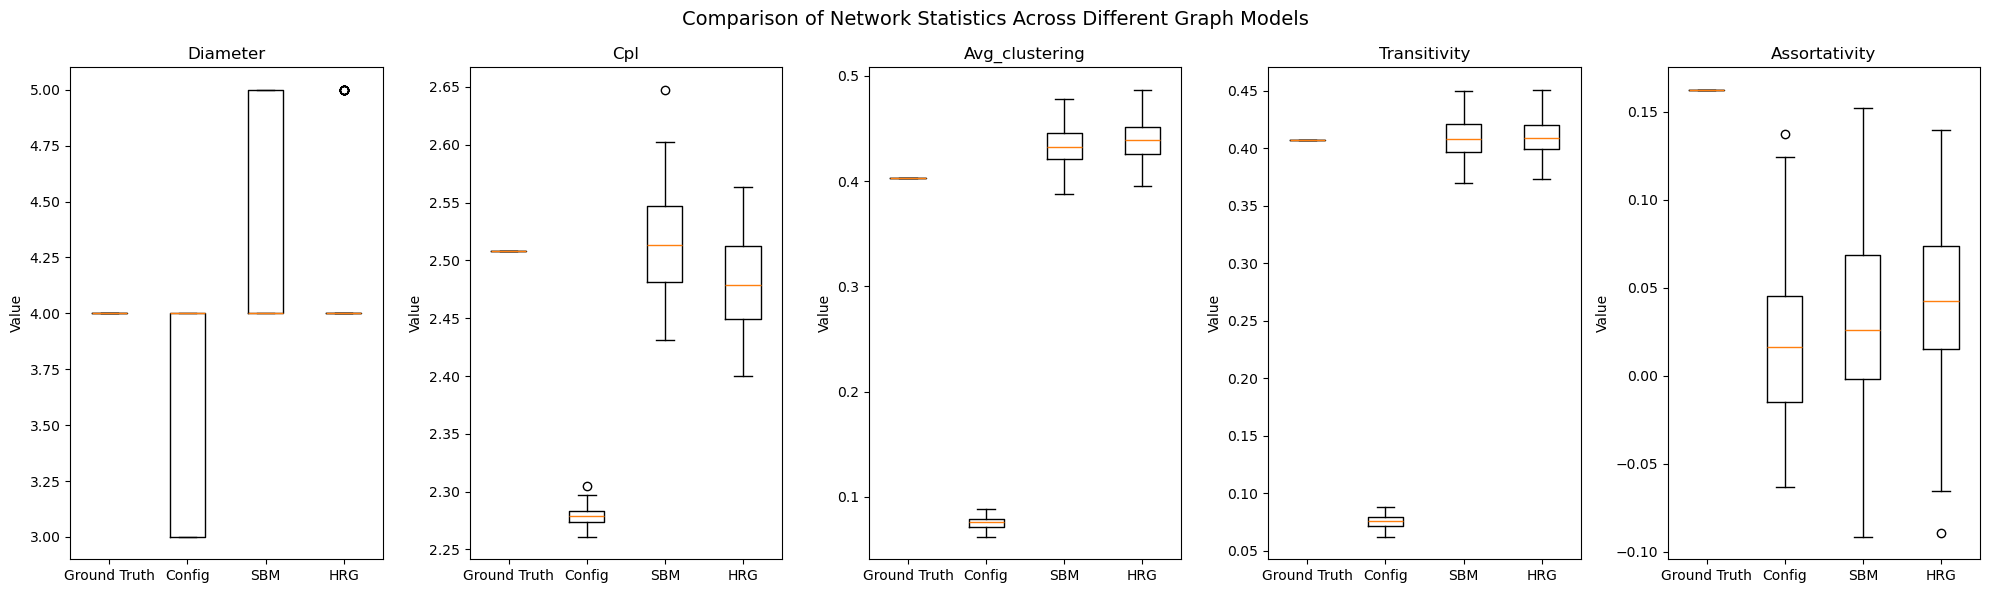

In [22]:
G = load_football_graph()
graph_stats = calculate_graph_statistics(G)

# Configuration Model
config_graphs = generate_configuration_graphs(graph_stats['degree_sequence'])

# Stochastic Block Model
resolutions, nmis = sweep_louvain_resolutions(G)
best_resolution, partition = calculate_best_partition(G, resolutions, nmis)
p, sizes = calculate_inter_community_density(G, partition)
sbm_graphs = generate_sbm_graphs(p, sizes)

# Hierarchical Random Graph Model
dendrogram = nx.read_gml("football-hrg.gml")
edge_probs = calculate_edge_probability(dendrogram)
hrg_graphs = generate_hrg_graphs(edge_probs)

# Calculating network characteristic statistics
config_stats = calculate_generated_statistics(config_graphs)
sbm_stats = calculate_generated_statistics(sbm_graphs)
hrg_stats = calculate_generated_statistics(hrg_graphs)

# Hypothesis Test Stats
print('Configuration Model t-test')
print(compare_generated_to_ground_truth(graph_stats, config_stats))

print('Stochastic Block Model t-test')
print(compare_generated_to_ground_truth(graph_stats, sbm_stats))

print('HRG Model t-test')
print(compare_generated_to_ground_truth(graph_stats, hrg_stats))

plot_graph_statistics([graph_stats, config_stats, sbm_stats, hrg_stats])

### 2.4 Written Response

Question: How do the statistics compare against the three different types of graph generators? Are there any particular measures that are very different? Can you explain how the algorithm for each generator influences the statistics that are different? Which graph generator would you say is the best fit for the ground truth? Justify your answer based on the t-test results and the box plots.

Answer: 
Three Graph Generation Models Comparison, based on t-test and box plots analysis below:

Configuration Model:
- All p-values extremely small (10^-10 to 10^-174), completely different from original network;
- Very low clustering (8.67e-173) and transitivity (8.63e-174), cannot show community structure;
- Only keeps degree distribution, loses other structural features.

Stochastic Block Model:
- Transitivity p=0.395 whichi is much higher than 0.05, means pretty good transitivity in network;
- Most features differ from original network;
- Good assortativity performance, p=0.002;
- Clustering and path lengths higher than true values.

Hierarchical Random Graph:
- Transitivity almost identical to original network, p=0.560;
- Even though the diameter is 0.0007 which is below 0.05, the overall performance is pretty good;
- Clustering coefficient low, but closer to true value than configuration model.

HRG model is most suitable for NCAA football network because it captures hierarchical structure, important for football leagues with natural organization levels.

Based On Network Sampling Analysis:

As sample size increases, network size estimates become more accurate:
- Sample 500: estimate much higher than true value, big error;
- Sample 2000: estimate close to true value, moderate error, about ±15,000;
- Sample 5000-10000: little improvement.

Based on balance of accuracy and efficiency, 2000 is most reasonable sample size, controlling costs while getting fairly accurate estimates.

## Part 3: Slashdot Network

In [25]:
def load_slashdot_graph() -> nx.Graph:
    # import "slashdot.txt"
    G = nx.read_edgelist("slashdot.txt", delimiter="\t", create_using=nx.DiGraph)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

### 3.1

In [27]:
def estimate_network_size(G, sample_sizes: List[int]=[500, 1000, 2000, 5000, 10000], n_iter: int=1000) -> Dict[str, List[int]]:
    """
    Inputs:
    G: NetworkX graph object
    sample_sizes: List[int]
    n_iter: int

    Returns:
    a dictionary where key is the sample size and the value is a list of the estimated network sizes for each trial
    """


    all_nodes = list(G.nodes())
    total_nodes = len(all_nodes)
    results = {size: [] for size in sample_sizes}
    
    for size in sample_sizes:
        count = 0
        while count < n_iter:
            # Calc the overpleap parts for sample1 and sample2
            sample1 = random.sample(all_nodes, size)
            sample2 = random.sample(all_nodes, size)
            n3 = len(set(sample1) & set(sample2))
            
            # If there's no overleap, contine
            if n3 == 0:
                continue
                
            # Evalueate by Mark-Recapture
            estimated_size = len(sample1) * len(sample2) // n3
            results[size].append(estimated_size)
            count += 1
            
    return results

def plot_estimate_histogram(estimated_sizes: List[int], true_size: int, save: bool=False) -> None:
    """
    Inputs:
    estimated_sizes: List[int]
    true_size: int
    save:boolean

    Returns:
    None
    """


    plt.figure(figsize=(12, 6))
    
    # Get the minimal vale and max value for setting position
    min_val = min(estimated_sizes)
    max_val = max(estimated_sizes)
    
    # Plot the graph, also could use 30
    plt.hist(estimated_sizes, bins=50, alpha=0.7, color='skyblue', edgecolor='black') 
    
    # Adding axv lines for the graph
    plt.axvline(x=true_size, color='red', linestyle='--', linewidth=2,
                label=f'True Size: {true_size}')
    
    # Set title and labels
    plt.title('Histogram of Estimated Network Sizes')
    plt.xlabel('Estimated Number of Nodes')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Adding grid lines 
    plt.grid(alpha=0.3)
    
    if save:
        plt.savefig('3_1_1.png')
    plt.tight_layout()
    plt.show()

def plot_sample_size_error(results: Dict[str, List[int]], true_size: int,
                           sample_sizes: List[int]=[500, 1000, 2000, 5000, 10000], save: bool=False) -> None:
    """
    Inputs:
    results: Dict[str, List[int]]
    true_size: int
    sample_sizes: List[int]
    save:boolean

    Returns:
    None
    """


    plt.figure(figsize=(12, 6))
    means = []
    stds = []
    
    for size in sample_sizes:
        estimates = results[size]
        means.append(np.mean(estimates))
        stds.append(np.std(estimates))
    
    # Represent standard deviation one above and one below 
    plt.errorbar(sample_sizes, means, yerr=stds, fmt='o-', capsize=5,
                linewidth=2, markersize=8, label='Estimated Size with Std Dev')
    
    plt.axhline(y=true_size, color='red', linestyle='--', linewidth=2,
               label=f'True Size: {true_size}')
    
    plt.title('Estimated Network Size vs Sample Size')
    plt.xlabel('Sample Size')
    plt.ylabel('Estimated Number of Nodes')
    plt.legend()
    plt.xticks(sample_sizes)
    plt.grid(alpha=0.3)
    
    if save:
        plt.savefig('3_1_2.png')
    
    plt.tight_layout()
    plt.show()


### 3.2

In [29]:
def estimate_edges(G: nx.Graph, n_sample: int=5000, n_iter: int=100) -> List[int]:
    """
    Inputs:
    G: NetworkX graph object
    n_sample: int
    n_iter: int

    Returns:
    a list of estimated_edges
    """


    all_nodes = list(G.nodes())
    total_nodes = len(all_nodes)
    estimated_edges = []
    
    for _ in range(n_iter):
        # Random samping, create sub grapph and calc the edges 
        sampled_nodes = random.sample(all_nodes, n_sample)
        subgraph = G.subgraph(sampled_nodes)
        edge_count = len(subgraph.edges())
        
        # Appling Horvitz-Thompson which is |E*| * N(N-1)/(n(n-1))
        estimated_edge_count = edge_count * (total_nodes * (total_nodes - 1)) / (n_sample * (n_sample - 1))
        estimated_edges.append(int(estimated_edge_count))
        
    return estimated_edges

def plot_edge_estimate_distribution(estimated_edges: List[int], true_edges: int, save: bool=False) -> None:
    """
    Inputs:
    estimated_edges: List[int]
    true_edges: int
    save: boolean

    Returns:
    None
    """


    plt.figure(figsize=(12, 6))
    
    # Set position by get min max values
    min_val = min(estimated_edges)
    max_val = max(estimated_edges)
    
    # Plot the graph
    plt.hist(estimated_edges, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    
    # Adding true edges 
    plt.axvline(x=true_edges, color='red', linestyle='--', linewidth=2,
                label=f'True Edges: {true_edges}')
    
    # Calc and add the mean, std estimate lines
    mean_estimate = np.mean(estimated_edges)
    std_estimate = np.std(estimated_edges)
    
    # Add the mean estimate lines 
    plt.axvline(x=mean_estimate, color='green', linestyle='-', linewidth=2,
                label=f'Mean Estimate: {mean_estimate:.0f} ± {std_estimate:.0f}')
    
    # Set the title and tags 
    plt.title('Distribution of Edge Count Estimates')
    plt.xlabel('Estimated Number of Edges')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Adding grid line
    plt.grid(alpha=0.3)
    
    if save:
        plt.savefig('3_2.png')
    plt.tight_layout()
    plt.show()

### 3.3

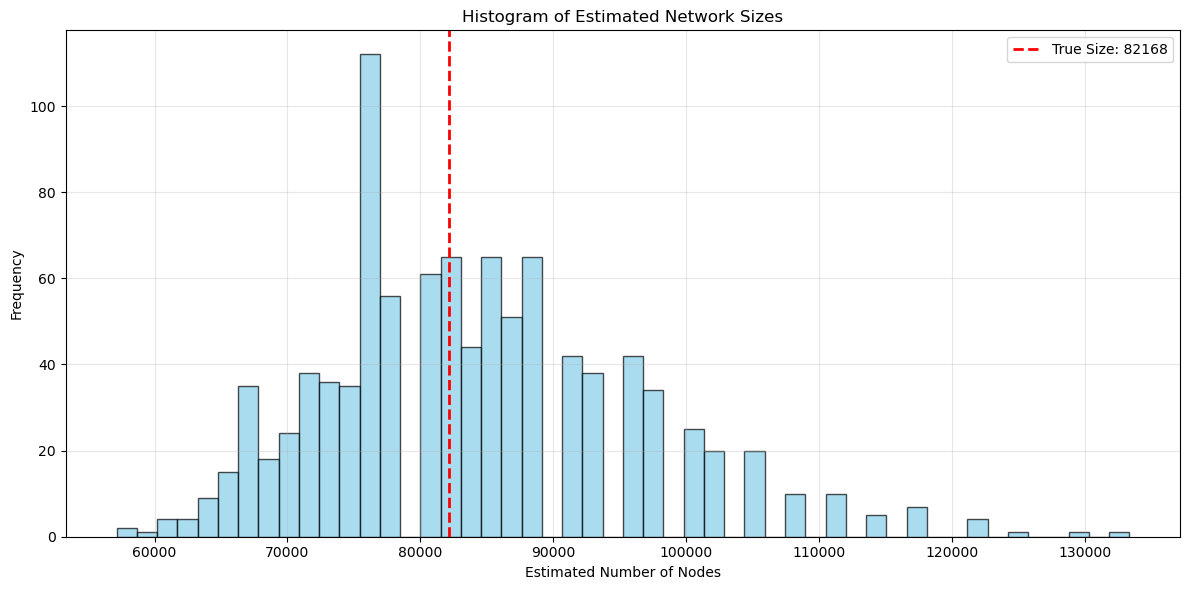

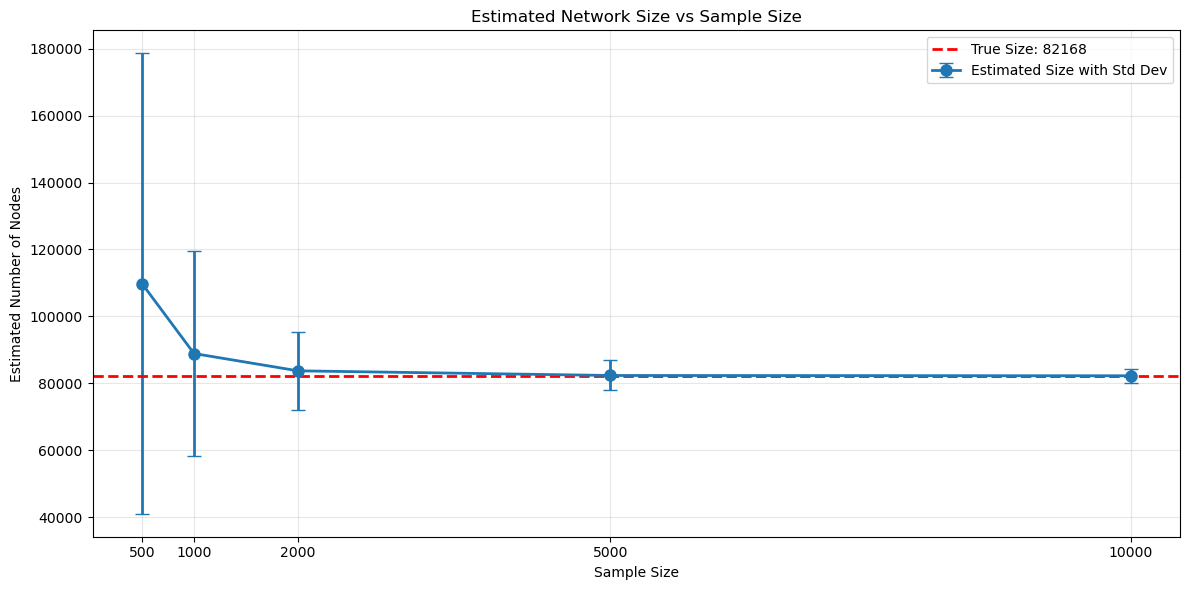

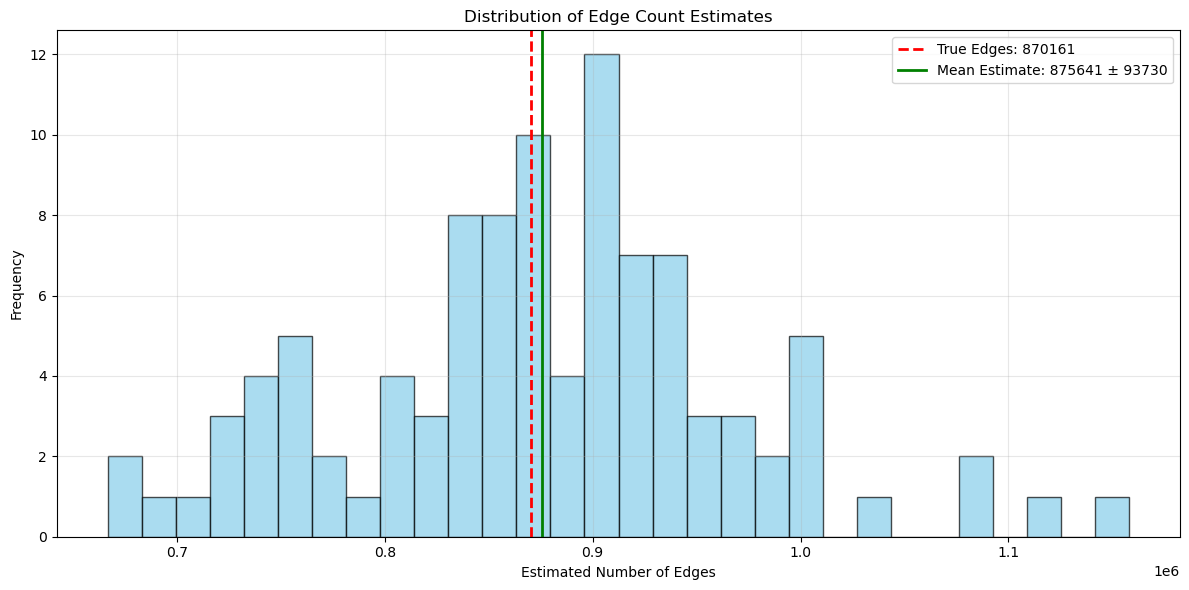

In [31]:
G = load_slashdot_graph()

network_size_estimates = estimate_network_size(G)

plot_estimate_histogram(network_size_estimates[2000], len(G.nodes()))
plot_sample_size_error(network_size_estimates, len(G.nodes()))

edge_estimates = estimate_edges(G)
plot_edge_estimate_distribution(edge_estimates, len(G.edges()))



### 3.3 Written Response

Question: How does the estimate of the number of nodes change as you increase the sample size? What is the smallest sample size you would consider a good choice for estimating the number of nodes?

Answer:
Based on plots, as sample size increases, network node count estimates change:

1. Estimation accuracy improves with sample size：
   - Sample size 500: estimate ~105,000, too high , very big standard devision (±70,000)
   - Sample size 1000: estimate drops to ~90,000, smaller standard devision (±30,000)
   - Sample size 2000: estimate near 85,000, closer to true value, even smaller standard devision (±15,000)
   - Sample sizes 5000 and 10000: estimates match true value (82,168), very small standard devision

2. Estimation variance decreases significantly with larger samples：
   - Small samples (500-1000) produce high variance estimates
   - Large samples (5000-10000) produce low variance, highly reliable estimates

Minimum ideal sample size should be 2000 because:
- Estimate already close to true value
- standard devision reduced to acceptable level
- Samples >2000 give diminishing returns
- Samples <2000 have excessive variance, unreliable

2000 samples provides good balance between computation efficiency and estimation accuracy